### Определение человеческой речи

Распознавание речи есть практически во всех мобильных устройствах, также оно работает на стационарных персональных компьютерах, в умных колонках, домашних устройствах, системах умного дома. Подавляющее большинство приборов интернета вещей (Internet of Things — сеть физических предметов, которые оснащены технологиями для взаимодействия друг с другом) уже имеют распознавание речи, а в перспективе нас ждет голосовое управление автомобилями и его мультимедийными системами.

Целью данного проекта является создание модели, которая будет отличать человеческую речь от постороннего шума (фоновые разговоры, синтезированый голос).

В качестве выборки мы имеет 2500 аудиофайлов с записью голосов и 2500 записей шума.

https://drive.google.com/drive/folders/1T9hmvN1mskD8vQdvKlwCgOG9desq4Yrh?usp=sharing - ссылка на данные



In [ ]:
import IPython.display as ipd
import pickle
# import PySimpleGUI as sg

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input, concatenate, Conv2D, MaxPool2D, Flatten, Conv1D, MaxPool1D, GlobalMaxPool2D, LSTM
from tensorflow.keras.optimizers import Adam

import librosa

import os
from google.colab import drive

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
path = '/content/drive/MyDrive/voice/'

In [ ]:
#Пример записи голоса
ipd.Audio(path + 'human/human_00001.wav')

In [ ]:
#Пример записи шума
ipd.Audio(path + 'spoof/spoof_00002.wav')

Извлечем из наших аудиофайлов все полезные признаки. 

In [ ]:
#Функция возвращает извлеченные из аудиофайла признаки
def get_features(x, sr):
  features=[]
    
  spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(x,sr=sr))
  spectral_centroid = np.mean(librosa.feature.spectral_centroid(x,sr=sr))
  spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(x,sr=sr))
  zero_crossing_rate = np.mean(librosa.feature.zero_crossing_rate(x))
  rms = np.mean(librosa.feature.rms(x))
  mfcc = librosa.feature.mfcc(x,sr=sr)
  chroma_stft = librosa.feature.chroma_stft(x,sr=sr)

  features.append(spectral_bandwidth)
  features.append(spectral_centroid)
  features.append(spectral_rolloff)
  features.append(zero_crossing_rate)
  features.append(rms)

  for i in mfcc:
    features.append(np.mean(i))

  for i in chroma_stft:
    features.append(np.mean(i))

  return features 

In [ ]:
#Пройдем по всем файлам и извлечем признаки
human_data = []
human_y = []

for i in range(2500):
    audio_path = path + 'human/human_{}.wav'.format(str(i).zfill(5))  

    au , sr = librosa.load(audio_path,mono=True)
    x, _ = librosa.effects.trim(au) #обрежем тишину вначале и в конце файла
    # x, sr = librosa.load(path + '{}/{}'.format(genre,audio),mono=True, duration=30)
    human_data.append(get_features(x, sr))
    human_y.append(1)

/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")


In [ ]:
#Пройдем по всем файлам и извлечем признаки
spoof_data = []
spoof_y = []

for i in range(2500):
    audio_path = path + 'spoof/spoof_{}.wav'.format(str(i).zfill(5))  

    au , sr = librosa.load(audio_path,mono=True)
    x, _ = librosa.effects.trim(au) #обрежем тишину вначале и в конце файла
    # x, sr = librosa.load(path + '{}/{}'.format(genre,audio),mono=True, duration=30)
    spoof_data.append(get_features(x, sr))
    spoof_y.append(0)

In [ ]:
#Объединим записи в одну выборку
x_data = np.vstack((human_data, spoof_data))
y = human_y + spoof_y

In [ ]:
print(x_data.shape)
print(len(y))

(5000, 37)
5000


In [ ]:
#Нормируем данные
scaler = StandardScaler()
x_data = scaler.fit_transform(x_data)

# scaler = MinMaxScaler()
# x_data = scaler.fit_transform(x_data)

In [ ]:
# #Сохраним выборку на всякий случай
# with open('/content/drive/MyDrive/voice/x_data.pickle', 'wb') as f: 
#   pickle.dump(x_data, f)

# with open('/content/drive/MyDrive/voice/y.pickle', 'wb') as f: 
#   pickle.dump(y, f)

In [ ]:
#Разобъем данные на обучающую и проверочную выборки
x_train, x_test, y_train, y_test = train_test_split(np.array(x_data), np.array(y), shuffle=True, stratify=y, test_size=0.2, random_state=56)

Epoch 1/50
250/250 [==============================] - 1s 4ms/step - loss: 0.5492 - accuracy: 0.7393 - val_loss: 0.3239 - val_accuracy: 0.8580
Epoch 2/50
250/250 [==============================] - 1s 3ms/step - loss: 0.3635 - accuracy: 0.8338 - val_loss: 0.2762 - val_accuracy: 0.8750
Epoch 3/50
250/250 [==============================] - 1s 3ms/step - loss: 0.3452 - accuracy: 0.8494 - val_loss: 0.2443 - val_accuracy: 0.8970
Epoch 4/50
250/250 [==============================] - 1s 3ms/step - loss: 0.2718 - accuracy: 0.8878 - val_loss: 0.2333 - val_accuracy: 0.9050
Epoch 5/50
250/250 [==============================] - 1s 3ms/step - loss: 0.2627 - accuracy: 0.8978 - val_loss: 0.2211 - val_accuracy: 0.9090
Epoch 6/50
250/250 [==============================] - 1s 3ms/step - loss: 0.2672 - accuracy: 0.8934 - val_loss: 0.2172 - val_accuracy: 0.9140
Epoch 7/50
250/250 [==============================] - 1s 3ms/step - loss: 0.2311 - accuracy: 0.9067 - val_loss: 0.2114 - val_accuracy: 0.9160
Epoch 

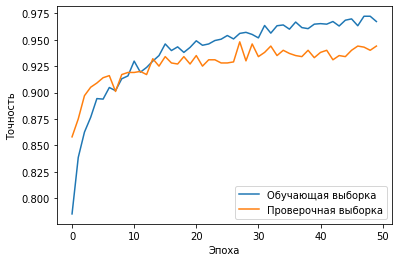

In [ ]:
#Обучим модель 
model = Sequential()
model.add(Dense(250, activation='relu', input_dim = x_train.shape[1]))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(150,activation='relu'))
# model.add(BatchNormalization())
model.add(Dropout(0.2))
# model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])
history = model.fit(x_train, y_train, epochs=50, batch_size=16, validation_data=(x_test,y_test))

plt.plot(history.history['accuracy'], label='Обучающая выборка')
plt.plot(history.history['val_accuracy'], label='Проверочная выборка')
plt.xlabel('Эпоха')
plt.ylabel('Точность')
plt.legend()
plt.show()

Epoch 1/10
250/250 [==============================] - 1s 3ms/step - loss: 0.0313 - accuracy: 0.9901 - val_loss: 0.2040 - val_accuracy: 0.9490
Epoch 2/10
250/250 [==============================] - 1s 3ms/step - loss: 0.0307 - accuracy: 0.9879 - val_loss: 0.2034 - val_accuracy: 0.9490
Epoch 3/10
250/250 [==============================] - 1s 3ms/step - loss: 0.0423 - accuracy: 0.9868 - val_loss: 0.1955 - val_accuracy: 0.9460
Epoch 4/10
250/250 [==============================] - 1s 3ms/step - loss: 0.0289 - accuracy: 0.9885 - val_loss: 0.2044 - val_accuracy: 0.9460
Epoch 5/10
250/250 [==============================] - 1s 3ms/step - loss: 0.0295 - accuracy: 0.9895 - val_loss: 0.2006 - val_accuracy: 0.9500
Epoch 6/10
250/250 [==============================] - 1s 3ms/step - loss: 0.0347 - accuracy: 0.9898 - val_loss: 0.2032 - val_accuracy: 0.9490
Epoch 7/10
250/250 [==============================] - 1s 3ms/step - loss: 0.0296 - accuracy: 0.9891 - val_loss: 0.2082 - val_accuracy: 0.9480
Epoch 

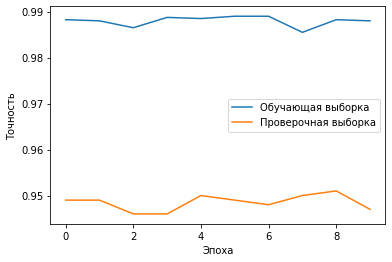

In [ ]:
#Дообучим модель
checkpoint = ModelCheckpoint('/content/drive/MyDrive/voice/voice.hdf5', monitor='val_accuracy', save_best_only=True, save_freq='epoch', mode='max')

model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0001), metrics=['accuracy'])
history = model.fit(x_train, y_train, epochs=10, batch_size=16, validation_data=(x_test,y_test), callbacks = [checkpoint])

plt.plot(history.history['accuracy'], label='Обучающая выборка')
plt.plot(history.history['val_accuracy'], label='Проверочная выборка')
plt.xlabel('Эпоха')
plt.ylabel('Точность')
plt.legend()
plt.show()

Я пробовал разные варианты архитектур, количества нейронов, функций активации и регуляризаций. В среднем точность колебалась в пределах 0.91-0.93. Лучшая точность на проверочной выборке получилась 0.951. 

Пробовал подавать входные вектора на несколько слоев, но улучшения добиться не удалось

Epoch 1/50
250/250 [==============================] - 2s 4ms/step - loss: 0.5072 - accuracy: 0.7422 - val_loss: 0.3638 - val_accuracy: 0.8500
Epoch 2/50
250/250 [==============================] - 1s 3ms/step - loss: 0.3277 - accuracy: 0.8587 - val_loss: 0.3055 - val_accuracy: 0.8700
Epoch 3/50
250/250 [==============================] - 1s 4ms/step - loss: 0.2576 - accuracy: 0.8921 - val_loss: 0.2678 - val_accuracy: 0.8940
Epoch 4/50
250/250 [==============================] - 1s 4ms/step - loss: 0.2227 - accuracy: 0.9149 - val_loss: 0.2448 - val_accuracy: 0.8890
Epoch 5/50
250/250 [==============================] - 1s 4ms/step - loss: 0.2106 - accuracy: 0.9165 - val_loss: 0.2318 - val_accuracy: 0.9150
Epoch 6/50
250/250 [==============================] - 1s 4ms/step - loss: 0.1877 - accuracy: 0.9266 - val_loss: 0.2289 - val_accuracy: 0.9120
Epoch 7/50
250/250 [==============================] - 1s 4ms/step - loss: 0.1588 - accuracy: 0.9320 - val_loss: 0.2461 - val_accuracy: 0.9010
Epoch 

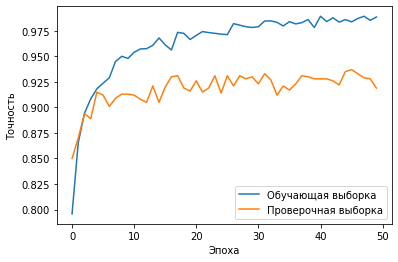

In [ ]:
#Обучим модель 
input = Input((37,))
x1 = Dense(250, activation='relu')(input)
x1 = Dense(50, activation='relu')(x1)

x2 = Dense(250, activation='elu')(input)
x2 = Dense(20, activation='softmax')(x2)

x = concatenate([x1,x2])

x = BatchNormalization()(x)
x = Dense(150,activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(50,activation='relu')(x)
x = Dropout(0.2)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(input, output)

model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])
history = model.fit(x_train, y_train, epochs=50, batch_size=16, validation_data=(x_test,y_test))

plt.plot(history.history['accuracy'], label='Обучающая выборка')
plt.plot(history.history['val_accuracy'], label='Проверочная выборка')
plt.xlabel('Эпоха')
plt.ylabel('Точность')
plt.legend()
plt.show()

Epoch 1/50
250/250 [==============================] - 2s 4ms/step - loss: 0.0184 - accuracy: 0.9934 - val_loss: 0.3601 - val_accuracy: 0.9310
Epoch 2/50
250/250 [==============================] - 1s 4ms/step - loss: 0.0134 - accuracy: 0.9963 - val_loss: 0.3645 - val_accuracy: 0.9310
Epoch 3/50
250/250 [==============================] - 1s 3ms/step - loss: 0.0086 - accuracy: 0.9978 - val_loss: 0.3655 - val_accuracy: 0.9320
Epoch 4/50
250/250 [==============================] - 1s 3ms/step - loss: 0.0083 - accuracy: 0.9964 - val_loss: 0.3830 - val_accuracy: 0.9320
Epoch 5/50
250/250 [==============================] - 1s 5ms/step - loss: 0.0116 - accuracy: 0.9963 - val_loss: 0.3914 - val_accuracy: 0.9380
Epoch 6/50
250/250 [==============================] - 1s 4ms/step - loss: 0.0125 - accuracy: 0.9974 - val_loss: 0.3905 - val_accuracy: 0.9380
Epoch 7/50
250/250 [==============================] - 1s 3ms/step - loss: 0.0085 - accuracy: 0.9983 - val_loss: 0.4021 - val_accuracy: 0.9360
Epoch 

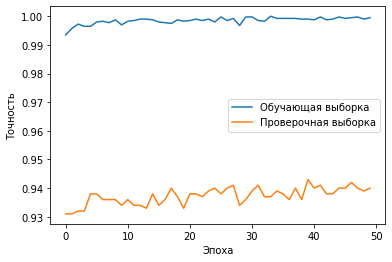

In [ ]:
#Дообучим модель
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0001), metrics=['accuracy'])
history = model.fit(x_train, y_train, epochs=50, batch_size=16, validation_data=(x_test,y_test))

plt.plot(history.history['accuracy'], label='Обучающая выборка')
plt.plot(history.history['val_accuracy'], label='Проверочная выборка')
plt.xlabel('Эпоха')
plt.ylabel('Точность')
plt.legend()
plt.show()

Пробовал различные комбинации признаков. Исключение spectral_bandwidth и spectral_rolloff не сильно влияет на качество. Исключение остальных уменьшает качество. Улучшения добиться не получилось

In [ ]:
ind = [0,1,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36]


Epoch 1/50
250/250 [==============================] - 1s 3ms/step - loss: 0.5692 - accuracy: 0.7245 - val_loss: 0.3161 - val_accuracy: 0.8650
Epoch 2/50
250/250 [==============================] - 1s 3ms/step - loss: 0.3633 - accuracy: 0.8353 - val_loss: 0.2781 - val_accuracy: 0.8760
Epoch 3/50
250/250 [==============================] - 1s 3ms/step - loss: 0.3217 - accuracy: 0.8642 - val_loss: 0.2621 - val_accuracy: 0.8840
Epoch 4/50
250/250 [==============================] - 1s 3ms/step - loss: 0.2816 - accuracy: 0.8759 - val_loss: 0.2444 - val_accuracy: 0.8920
Epoch 5/50
250/250 [==============================] - 1s 3ms/step - loss: 0.2563 - accuracy: 0.8942 - val_loss: 0.2386 - val_accuracy: 0.8930
Epoch 6/50
250/250 [==============================] - 1s 3ms/step - loss: 0.2747 - accuracy: 0.8815 - val_loss: 0.2444 - val_accuracy: 0.8930
Epoch 7/50
250/250 [==============================] - 1s 3ms/step - loss: 0.2314 - accuracy: 0.9052 - val_loss: 0.2286 - val_accuracy: 0.9090
Epoch 

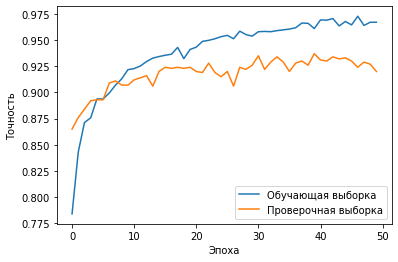

In [ ]:
#Попробуем отобрать признаки
xx = x_train[:, ind]
xv = x_test[:, ind]

#Обучим модель 
model = Sequential()
model.add(Dense(250, activation='relu', input_dim = xx.shape[1]))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(150,activation='relu'))
# model.add(BatchNormalization())
model.add(Dropout(0.2))
# model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])
history = model.fit(xx, y_train, epochs=50, batch_size=16, validation_data=(xv,y_test))

plt.plot(history.history['accuracy'], label='Обучающая выборка')
plt.plot(history.history['val_accuracy'], label='Проверочная выборка')
plt.xlabel('Эпоха')
plt.ylabel('Точность')
plt.legend()
plt.show()

Epoch 1/50
250/250 [==============================] - 1s 3ms/step - loss: 0.0723 - accuracy: 0.9714 - val_loss: 0.2183 - val_accuracy: 0.9290
Epoch 2/50
250/250 [==============================] - 1s 3ms/step - loss: 0.0666 - accuracy: 0.9765 - val_loss: 0.2117 - val_accuracy: 0.9330
Epoch 3/50
250/250 [==============================] - 1s 3ms/step - loss: 0.0649 - accuracy: 0.9780 - val_loss: 0.2095 - val_accuracy: 0.9290
Epoch 4/50
250/250 [==============================] - 1s 3ms/step - loss: 0.0554 - accuracy: 0.9784 - val_loss: 0.2079 - val_accuracy: 0.9350
Epoch 5/50
250/250 [==============================] - 1s 3ms/step - loss: 0.0638 - accuracy: 0.9738 - val_loss: 0.2071 - val_accuracy: 0.9380
Epoch 6/50
250/250 [==============================] - 1s 3ms/step - loss: 0.0579 - accuracy: 0.9778 - val_loss: 0.2080 - val_accuracy: 0.9340
Epoch 7/50
250/250 [==============================] - 1s 3ms/step - loss: 0.0445 - accuracy: 0.9847 - val_loss: 0.2103 - val_accuracy: 0.9340
Epoch 

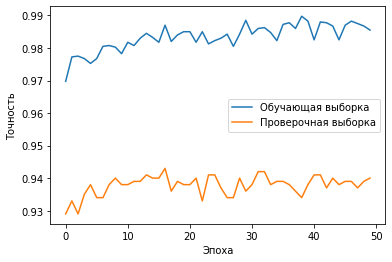

In [ ]:
#Дообучим модель
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0001), metrics=['accuracy'])
history = model.fit(xx, y_train, epochs=50, batch_size=16, validation_data=(xv,y_test))

plt.plot(history.history['accuracy'], label='Обучающая выборка')
plt.plot(history.history['val_accuracy'], label='Проверочная выборка')
plt.xlabel('Эпоха')
plt.ylabel('Точность')
plt.legend()
plt.show()

Попробуем подругому обработать нашу выборку и обучить сверточную модель 

In [ ]:
#Функция возвращает извлеченные из аудиофайла признаки
def get_all_features(x, sr):
    
  spectral_centroid = librosa.feature.spectral_centroid(x,sr=sr)
  rms = librosa.feature.rms(x)
  mfcc = librosa.feature.mfcc(x,sr=sr)
  chroma_stft = librosa.feature.chroma_stft(x,sr=sr)


  return spectral_centroid, rms, mfcc, chroma_stft

In [ ]:
#Пройдем по всем файлам и извлечем признаки
x_spec = []
x_rms = []
x_mfcc = []
x_stft = []
y = []

for i in range(2500):
    audio_path = path + 'human/human_{}.wav'.format(str(i).zfill(5))  

    au , sr = librosa.load(audio_path,mono=True, duration=5)
    x, _ = librosa.effects.trim(au) #обрежем тишину вначале и в конце файла
    # x, sr = librosa.load(path + '{}/{}'.format(genre,audio),mono=True, duration=30)
    second = round(len(x)/sr) - 1
    for sec in range(second):

      s,r,m,c = get_all_features(x[sec*sr:(sec+1)*sr], sr)

      x_spec.append(s)
      x_rms.append(r)
      x_mfcc.append(m)
      x_stft.append(c)
      y.append(1)

    
for i in range(2500):
    audio_path = path + 'spoof/spoof_{}.wav'.format(str(i).zfill(5))  

    au , sr = librosa.load(audio_path,mono=True, duration=5)
    x, _ = librosa.effects.trim(au) #обрежем тишину вначале и в конце файла
    # x, sr = librosa.load(path + '{}/{}'.format(genre,audio),mono=True, duration=30)
    second = round(len(x)/sr) - 1
    for sec in range(second):

      s,r,m,c = get_all_features(x[sec*sr:(sec+1)*sr], sr)

      x_spec.append(s)
      x_rms.append(r)
      x_mfcc.append(m)
      x_stft.append(c)
      y.append(0)

/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")


In [ ]:
x_spec = np.array(x_spec)
x_rms = np.array(x_rms)
x_mfcc = np.array(x_mfcc)
x_stft = np.array(x_stft)

y = np.array(y)

In [ ]:
print(x_spec.shape)
print(x_rms.shape)
print(x_mfcc.shape)
print(x_stft.shape)

(13934, 1, 44)
(13934, 1, 44)
(13934, 20, 44)
(13934, 12, 44)


In [ ]:
#Поменяем размерность
x_spec1 = x_spec.reshape(x_spec.shape[0],x_spec.shape[2],x_spec.shape[1])
x_rms1 = x_rms.reshape(x_rms.shape[0],x_rms.shape[2],x_rms.shape[1])
x_mfcc1 = x_mfcc.reshape(x_mfcc.shape[0],x_mfcc.shape[1],x_mfcc.shape[2],1)
x_stft1 = x_stft.reshape(x_stft.shape[0],x_stft.shape[1],x_stft.shape[2],1)

In [ ]:
print(x_spec1.shape)
print(x_rms1.shape)
print(x_mfcc1.shape)
print(x_stft1.shape)

(13934, 44, 1)
(13934, 44, 1)
(13934, 20, 44, 1)
(13934, 12, 44, 1)


In [ ]:
# #Сохраним выборку на всякий случай
# with open('/content/drive/MyDrive/voice/x_spec.pickle', 'wb') as f: 
#   pickle.dump(x_spec, f)

# with open('/content/drive/MyDrive/voice/x_rms.pickle', 'wb') as f: 
#   pickle.dump(x_rms, f)

# with open('/content/drive/MyDrive/voice/x_mfcc.pickle', 'wb') as f: 
#   pickle.dump(x_mfcc, f)

# with open('/content/drive/MyDrive/voice/x_stft.pickle', 'wb') as f: 
#   pickle.dump(x_stft, f)

# with open('/content/drive/MyDrive/voice/y.pickle', 'wb') as f: 
#   pickle.dump(y, f)


In [ ]:
#Функция нормировки
def scale(X):
  min_x = X.min()
  max_x = X.max()
  X = (X - min_x) / (max_x - min_x)
  return X

In [ ]:
x_spec1 = scale(x_spec1)
x_rms1 = scale(x_rms1)
x_mfcc1 = scale(x_mfcc1)
x_stft1 = scale(x_stft1)

In [ ]:
#Создадим маску для разделения выборки на обучающую и проверочную
val_mask = np.random.sample(13934)
train_mask = val_mask < 0.9
val_mask = val_mask >= 0.9

Epoch 1/10
199/199 [==============================] - 5s 21ms/step - loss: 0.6443 - accuracy: 0.6656 - val_loss: 0.7220 - val_accuracy: 0.4647
Epoch 2/10
199/199 [==============================] - 4s 20ms/step - loss: 0.3993 - accuracy: 0.8154 - val_loss: 1.2235 - val_accuracy: 0.5020
Epoch 3/10
199/199 [==============================] - 4s 20ms/step - loss: 0.3507 - accuracy: 0.8445 - val_loss: 0.3776 - val_accuracy: 0.8197
Epoch 4/10
199/199 [==============================] - 4s 20ms/step - loss: 0.3022 - accuracy: 0.8748 - val_loss: 0.4454 - val_accuracy: 0.7840
Epoch 5/10
199/199 [==============================] - 4s 20ms/step - loss: 0.3017 - accuracy: 0.8708 - val_loss: 0.2848 - val_accuracy: 0.8785
Epoch 6/10
199/199 [==============================] - 4s 20ms/step - loss: 0.2046 - accuracy: 0.9162 - val_loss: 0.5259 - val_accuracy: 0.7887
Epoch 7/10
199/199 [==============================] - 4s 20ms/step - loss: 0.1841 - accuracy: 0.9257 - val_loss: 0.3277 - val_accuracy: 0.8515

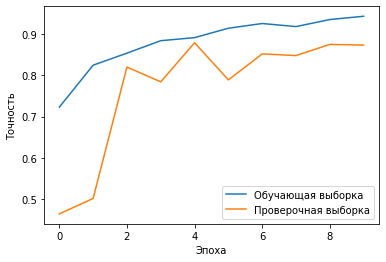

In [ ]:
#Обучим модель 

input1 = Input((44,1)) 
input2 = Input((44,1)) 
input3 = Input((20,44,1)) 
input4 = Input((12,44,1))

# x1 = BatchNormalization()(input1)
# x1 = Conv1D(150, 3, padding='same', activation='relu')(x1)
# x1 = Conv1D(150, 3, padding='same', activation='relu')(x1)
# x1 = MaxPool1D(3)(x1)
# x1 = Conv1D(50, 3, padding='same', activation='relu')(x1)
# x1 = Conv1D(50, 3, padding='same', activation='relu')(x1)
# x1 = MaxPool1D(3)(x1)
# x1 = Flatten()(x1)

# x2 = BatchNormalization()(input2)
# x2 = Conv1D(150, 3, padding='same', activation='relu')(x2)
# x2 = Conv1D(150, 3, padding='same', activation='relu')(x2)
# x2 = MaxPool1D(3)(x2)
# x2 = Conv1D(50, 3, padding='same', activation='relu')(x2)
# x2 = Conv1D(50, 3, padding='same', activation='relu')(x2)
# x2 = MaxPool1D(3)(x2)
# x2 = Flatten()(x2)

x3 = BatchNormalization()(input3)
x3 = Conv2D(150, (3,3), padding='same', activation='relu')(x3)
x3 = Conv2D(150, (3,3), padding='same', activation='relu')(x3)
x3 = MaxPool2D(3)(x3)
x3_g1 = GlobalMaxPool2D()(x3)
x3 = Conv2D(50, (3,3), padding='same', activation='relu')(x3)
x3 = Conv2D(50, (3,3), padding='same', activation='relu')(x3)
# x3 = MaxPool2D(3)(x3)
x3_g2 = GlobalMaxPool2D()(x3)
x3 = Flatten()(x3)

# x4 = BatchNormalization()(input4)
# x4 = Conv2D(150, (3,3), padding='same', activation='relu')(x4)
# x4 = Conv2D(150, (3,3), padding='same', activation='relu')(x4)
# x4 = MaxPool2D(3)(x4)
# # x4_g1 = GlobalMaxPool2D()(x4)
# x4 = Conv2D(50, (3,3), padding='same', activation='relu')(x4)
# x4 = Conv2D(50, (3,3), padding='same', activation='relu')(x4)
# # x4 = MaxPool2D(3)(x4)
# x4_g2 = GlobalMaxPool2D()(x4)
# x4 = Flatten()(x4)

x = concatenate([x3,x3_g1,x3_g2])

x = Dense(250, activation='tanh')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(150, activation='relu')(x)
x = Dropout(0.2)(x)
output = Dense(1, activation='sigmoid')(x)


model = Model([input1,input2,input3,input4], output)

model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])
history = model.fit([x_spec1[train_mask], x_rms1[train_mask], x_mfcc1[train_mask], x_stft1[train_mask]], y[train_mask], epochs=10, batch_size=64,
                    validation_data=([x_spec1[val_mask], x_rms1[val_mask], x_mfcc1[val_mask], x_stft1[val_mask]],y[val_mask]))

plt.plot(history.history['accuracy'], label='Обучающая выборка')
plt.plot(history.history['val_accuracy'], label='Проверочная выборка')
plt.xlabel('Эпоха')
plt.ylabel('Точность')
plt.legend()
plt.show()


In [ ]:
#Дообучим модель
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0001), metrics=['accuracy'])
history = model.fit([x_spec1[train_mask], x_rms1[train_mask], x_mfcc1[train_mask], x_stft1[train_mask]], y[train_mask], epochs=20, batch_size=64,
                    validation_data=([x_spec1[val_mask], x_rms1[val_mask], x_mfcc1[val_mask], x_stft1[val_mask]],y[val_mask]))

plt.plot(history.history['accuracy'], label='Обучающая выборка')
plt.plot(history.history['val_accuracy'], label='Проверочная выборка')
plt.xlabel('Эпоха')
plt.ylabel('Точность')
plt.legend()
plt.show()

Epoch 1/20
199/199 [==============================] - 5s 21ms/step - loss: 0.0960 - accuracy: 0.9648 - val_loss: 0.1902 - val_accuracy: 0.9261
Epoch 2/20
199/199 [==============================] - 4s 20ms/step - loss: 0.0624 - accuracy: 0.9767 - val_loss: 0.1959 - val_accuracy: 0.9301
Epoch 3/20
199/199 [==============================] - 4s 20ms/step - loss: 0.0516 - accuracy: 0.9839 - val_loss: 0.2106 - val_accuracy: 0.9253
Epoch 4/20
199/199 [==============================] - 4s 20ms/step - loss: 0.0408 - accuracy: 0.9876 - val_loss: 0.2710 - val_accuracy: 0.9007
Epoch 5/20
199/199 [==============================] - 4s 20ms/step - loss: 0.0410 - accuracy: 0.9874 - val_loss: 0.2306 - val_accuracy: 0.9261
Epoch 6/20
199/199 [==============================] - 4s 21ms/step - loss: 0.0402 - accuracy: 0.9850 - val_loss: 0.2256 - val_accuracy: 0.9237
Epoch 7/20
199/199 [==============================] - 4s 20ms/step - loss: 0.0311 - accuracy: 0.9896 - val_loss: 0.2288 - val_accuracy: 0.9245

KeyboardInterrupt: ignored

Лучшего качества добиться не получилось, но была найдена интересная особенность. Вся полезная для сверточной модели информация содержиться в одном признаке mmfc. Попроуем разные варианты архитектуры сверточной модели на этом одном признаке 

Epoch 1/10
199/199 [==============================] - 10s 42ms/step - loss: 0.6499 - accuracy: 0.6420 - val_loss: 2.7107 - val_accuracy: 0.5417
Epoch 2/10
199/199 [==============================] - 8s 41ms/step - loss: 0.5398 - accuracy: 0.7343 - val_loss: 2.0851 - val_accuracy: 0.5417
Epoch 3/10
199/199 [==============================] - 8s 41ms/step - loss: 0.4020 - accuracy: 0.8141 - val_loss: 0.4340 - val_accuracy: 0.8197
Epoch 4/10
199/199 [==============================] - 8s 42ms/step - loss: 0.3278 - accuracy: 0.8572 - val_loss: 1.0559 - val_accuracy: 0.6187
Epoch 5/10
199/199 [==============================] - 8s 42ms/step - loss: 0.2688 - accuracy: 0.8893 - val_loss: 0.4206 - val_accuracy: 0.8515
Epoch 6/10
199/199 [==============================] - 8s 41ms/step - loss: 0.2377 - accuracy: 0.9068 - val_loss: 0.3324 - val_accuracy: 0.8681
Epoch 7/10
199/199 [==============================] - 8s 41ms/step - loss: 0.2112 - accuracy: 0.9139 - val_loss: 0.3410 - val_accuracy: 0.876

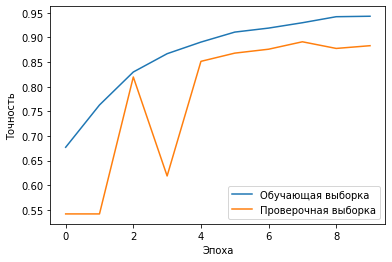

In [ ]:
#Обучим модель 

input3 = Input((20,44,1)) 


x3 = BatchNormalization()(input3)
# x3_a = GlobalMaxPool2D()(x3)
x3 = Conv2D(150, (4,4), padding='same', activation='relu')(x3)
x3 = Conv2D(150, (4,4), padding='same', activation='relu')(x3)
x3 = MaxPool2D(3)(x3)
# x3_g1 = GlobalMaxPool2D()(x3)
x3 = Conv2D(100, (4,4), padding='same', activation='relu')(x3)
x3 = Conv2D(100, (4,4), padding='same', activation='relu')(x3)
# x3 = MaxPool2D(2)(x3)
x3_g2 = GlobalMaxPool2D()(x3)
# x3 = Conv2D(50, (3,3), padding='same', activation='relu')(x3)
# x3 = Conv2D(50, (3,3), padding='same', activation='relu')(x3)
x3 = Flatten()(x3)


x = concatenate([x3,x3_g2])

x = Dense(250, activation='tanh')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(150, activation='relu')(x)
x = Dropout(0.2)(x)
output = Dense(1, activation='sigmoid')(x)


model = Model(input3, output)

model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])
history = model.fit(x_mfcc1[train_mask], y[train_mask], epochs=10, batch_size=64,
                    validation_data=(x_mfcc1[val_mask] ,y[val_mask]))

plt.plot(history.history['accuracy'], label='Обучающая выборка')
plt.plot(history.history['val_accuracy'], label='Проверочная выборка')
plt.xlabel('Эпоха')
plt.ylabel('Точность')
plt.legend()
plt.show()


Epoch 1/10
199/199 [==============================] - 9s 41ms/step - loss: 0.0707 - accuracy: 0.9744 - val_loss: 0.2027 - val_accuracy: 0.9357
Epoch 2/10
199/199 [==============================] - 8s 41ms/step - loss: 0.0387 - accuracy: 0.9867 - val_loss: 0.2127 - val_accuracy: 0.9357
Epoch 3/10
199/199 [==============================] - 8s 41ms/step - loss: 0.0269 - accuracy: 0.9907 - val_loss: 0.2632 - val_accuracy: 0.9261
Epoch 4/10
199/199 [==============================] - 8s 42ms/step - loss: 0.0218 - accuracy: 0.9928 - val_loss: 0.2688 - val_accuracy: 0.9253
Epoch 5/10
199/199 [==============================] - 8s 42ms/step - loss: 0.0190 - accuracy: 0.9942 - val_loss: 0.2676 - val_accuracy: 0.9301
Epoch 6/10
199/199 [==============================] - 8s 41ms/step - loss: 0.0253 - accuracy: 0.9901 - val_loss: 0.2699 - val_accuracy: 0.9341
Epoch 7/10
199/199 [==============================] - 8s 41ms/step - loss: 0.0182 - accuracy: 0.9942 - val_loss: 0.2667 - val_accuracy: 0.9341

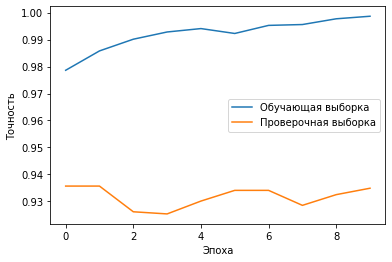

In [ ]:
#Дообучим модель
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0001), metrics=['accuracy'])
history = model.fit(x_mfcc1[train_mask], y[train_mask], epochs=10, batch_size=64,
                    validation_data=(x_mfcc1[val_mask] ,y[val_mask]))

plt.plot(history.history['accuracy'], label='Обучающая выборка')
plt.plot(history.history['val_accuracy'], label='Проверочная выборка')
plt.xlabel('Эпоха')
plt.ylabel('Точность')
plt.legend()
plt.show()

Улучшить результат не получилось.

Попробуем обучить модель с LSTM

In [ ]:
#Отнормируем признак, который был до изменения размерности
x_mfcc2 = scale(x_mfcc)

Epoch 1/10
199/199 [==============================] - 8s 21ms/step - loss: 0.6436 - accuracy: 0.6353 - val_loss: 0.6937 - val_accuracy: 0.5271
Epoch 2/10
199/199 [==============================] - 3s 16ms/step - loss: 0.5960 - accuracy: 0.6768 - val_loss: 0.6745 - val_accuracy: 0.5618
Epoch 3/10
199/199 [==============================] - 3s 15ms/step - loss: 0.5918 - accuracy: 0.6792 - val_loss: 0.6540 - val_accuracy: 0.6469
Epoch 4/10
199/199 [==============================] - 3s 15ms/step - loss: 0.5650 - accuracy: 0.7000 - val_loss: 0.5719 - val_accuracy: 0.6975
Epoch 5/10
199/199 [==============================] - 3s 16ms/step - loss: 0.5592 - accuracy: 0.7033 - val_loss: 0.5917 - val_accuracy: 0.6843
Epoch 6/10
199/199 [==============================] - 3s 16ms/step - loss: 0.5197 - accuracy: 0.7364 - val_loss: 0.5743 - val_accuracy: 0.6815
Epoch 7/10
199/199 [==============================] - 3s 16ms/step - loss: 0.5073 - accuracy: 0.7437 - val_loss: 0.5179 - val_accuracy: 0.7404

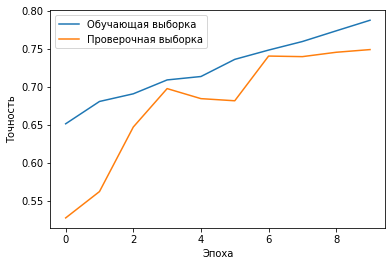

In [ ]:
#Обучим модель LSTM 

input3 = Input((20,44)) 

x3 = BatchNormalization()(input3)
x3 = LSTM(500, return_sequences=True)(x3)
x3 = LSTM(400,return_sequences=True)(x3)
x3 = LSTM(100,return_sequences=True)(x3)

# x3 = Flatten()(x3)


x = Dense(50, activation='sigmoid')(x3)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(50, activation='relu')(x)
x = Dropout(0.1)(x)
output = Dense(1, activation='sigmoid')(x)


model = Model(input3, output)

model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])
history = model.fit(x_mfcc2[train_mask], y[train_mask], epochs=10, batch_size=64,
                    validation_data=(x_mfcc2[val_mask] ,y[val_mask]))

plt.plot(history.history['accuracy'], label='Обучающая выборка')
plt.plot(history.history['val_accuracy'], label='Проверочная выборка')
plt.xlabel('Эпоха')
plt.ylabel('Точность')
plt.legend()
plt.show()


Epoch 1/10
199/199 [==============================] - 7s 19ms/step - loss: 0.3215 - accuracy: 0.8609 - val_loss: 0.3708 - val_accuracy: 0.8443
Epoch 2/10
199/199 [==============================] - 3s 14ms/step - loss: 0.2893 - accuracy: 0.8721 - val_loss: 0.3590 - val_accuracy: 0.8459
Epoch 3/10
199/199 [==============================] - 3s 14ms/step - loss: 0.2747 - accuracy: 0.8782 - val_loss: 0.3595 - val_accuracy: 0.8419
Epoch 4/10
199/199 [==============================] - 3s 15ms/step - loss: 0.2613 - accuracy: 0.8866 - val_loss: 0.3591 - val_accuracy: 0.8451
Epoch 5/10
199/199 [==============================] - 3s 14ms/step - loss: 0.2604 - accuracy: 0.8890 - val_loss: 0.3650 - val_accuracy: 0.8475
Epoch 6/10
199/199 [==============================] - 3s 14ms/step - loss: 0.2565 - accuracy: 0.8914 - val_loss: 0.3512 - val_accuracy: 0.8467
Epoch 7/10
199/199 [==============================] - 3s 15ms/step - loss: 0.2470 - accuracy: 0.8966 - val_loss: 0.3542 - val_accuracy: 0.8539

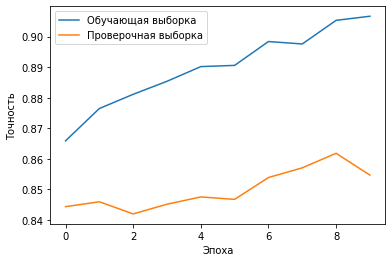

In [ ]:
#Дообучим модель
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0001), metrics=['accuracy'])
history = model.fit(x_mfcc2[train_mask], y[train_mask], epochs=10, batch_size=64,
                    validation_data=(x_mfcc2[val_mask] ,y[val_mask]))

plt.plot(history.history['accuracy'], label='Обучающая выборка')
plt.plot(history.history['val_accuracy'], label='Проверочная выборка')
plt.xlabel('Эпоха')
plt.ylabel('Точность')
plt.legend()
plt.show()

Результат неплохой, но заметно хуже, чем сверточная сеть

Попробуем объединить сверточную модель и рекурентную

Epoch 1/10
199/199 [==============================] - 9s 41ms/step - loss: 0.5864 - accuracy: 0.6913 - val_loss: 0.7920 - val_accuracy: 0.4583
Epoch 2/10
199/199 [==============================] - 8s 40ms/step - loss: 0.3875 - accuracy: 0.8321 - val_loss: 0.6390 - val_accuracy: 0.6092
Epoch 3/10
199/199 [==============================] - 8s 41ms/step - loss: 0.2950 - accuracy: 0.8730 - val_loss: 0.5319 - val_accuracy: 0.7522
Epoch 4/10
199/199 [==============================] - 8s 41ms/step - loss: 0.2494 - accuracy: 0.8950 - val_loss: 1.2352 - val_accuracy: 0.6187
Epoch 5/10
199/199 [==============================] - 8s 41ms/step - loss: 0.3159 - accuracy: 0.8639 - val_loss: 0.3368 - val_accuracy: 0.8658
Epoch 6/10
199/199 [==============================] - 9s 45ms/step - loss: 0.2880 - accuracy: 0.8738 - val_loss: 0.7116 - val_accuracy: 0.7014
Epoch 7/10
199/199 [==============================] - 8s 41ms/step - loss: 0.1612 - accuracy: 0.9339 - val_loss: 0.3956 - val_accuracy: 0.8300

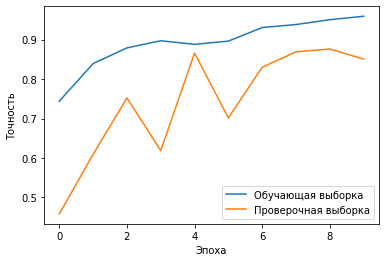

In [ ]:
#Обучим модель с Conv2d и LSTM
input3 = Input((20,44,1)) 
input2 = Input((20,44)) 

x2 = BatchNormalization()(input2)
x2 = LSTM(300, return_sequences=True)(x2)
x2 = LSTM(200,return_sequences=True)(x2)
x2 = LSTM(100,return_sequences=True)(x2)
x2 = Flatten()(x2)

x3 = BatchNormalization()(input3)
# x3_a = GlobalMaxPool2D()(x3)
x3 = Conv2D(150, (4,4), padding='same', activation='relu')(x3)
x3 = Conv2D(150, (4,4), padding='same', activation='relu')(x3)
x3 = MaxPool2D(3)(x3)
# x3_g1 = GlobalMaxPool2D()(x3)
x3 = Conv2D(100, (4,4), padding='same', activation='relu')(x3)
x3 = Conv2D(100, (4,4), padding='same', activation='relu')(x3)
# x3 = MaxPool2D(2)(x3)
x3_g2 = GlobalMaxPool2D()(x3)
# x3 = Conv2D(50, (3,3), padding='same', activation='relu')(x3)
# x3 = Conv2D(50, (3,3), padding='same', activation='relu')(x3)
x3 = Flatten()(x3)

x = concatenate([x2,x3,x3_g2])

x = Dense(250, activation='sigmoid')(x3)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(150, activation='relu')(x)
x = Dropout(0.1)(x)
output = Dense(1, activation='sigmoid')(x)


model = Model([input2, input3], output)

model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])
history = model.fit([x_mfcc2[train_mask], x_mfcc1[train_mask]], y[train_mask], epochs=10, batch_size=64,
                    validation_data=([x_mfcc2[val_mask], x_mfcc1[val_mask]] ,y[val_mask]))

plt.plot(history.history['accuracy'], label='Обучающая выборка')
plt.plot(history.history['val_accuracy'], label='Проверочная выборка')
plt.xlabel('Эпоха')
plt.ylabel('Точность')
plt.legend()
plt.show()

Epoch 1/10
199/199 [==============================] - 9s 40ms/step - loss: 0.0104 - accuracy: 0.9980 - val_loss: 0.2476 - val_accuracy: 0.9349
Epoch 2/10
199/199 [==============================] - 8s 40ms/step - loss: 0.0091 - accuracy: 0.9976 - val_loss: 0.2543 - val_accuracy: 0.9373
Epoch 3/10
199/199 [==============================] - 8s 40ms/step - loss: 0.0073 - accuracy: 0.9981 - val_loss: 0.2730 - val_accuracy: 0.9293
Epoch 4/10
199/199 [==============================] - 8s 41ms/step - loss: 0.0199 - accuracy: 0.9929 - val_loss: 0.2474 - val_accuracy: 0.9365
Epoch 5/10
199/199 [==============================] - 8s 41ms/step - loss: 0.0149 - accuracy: 0.9958 - val_loss: 0.2791 - val_accuracy: 0.9357
Epoch 6/10
199/199 [==============================] - 8s 41ms/step - loss: 0.0039 - accuracy: 0.9993 - val_loss: 0.2712 - val_accuracy: 0.9373
Epoch 7/10
199/199 [==============================] - 8s 41ms/step - loss: 0.0028 - accuracy: 0.9997 - val_loss: 0.2598 - val_accuracy: 0.9341

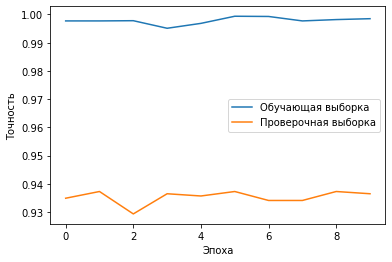

In [ ]:
#Дообучим модель
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0001), metrics=['accuracy'])
history = model.fit([x_mfcc2[train_mask], x_mfcc1[train_mask]], y[train_mask], epochs=10, batch_size=64,
                    validation_data=([x_mfcc2[val_mask], x_mfcc1[val_mask]] ,y[val_mask]))

plt.plot(history.history['accuracy'], label='Обучающая выборка')
plt.plot(history.history['val_accuracy'], label='Проверочная выборка')
plt.xlabel('Эпоха')
plt.ylabel('Точность')
plt.legend()
plt.show()

Результат лучше не стал, но достигнута большая стабильность проверочной кривой.



Итог: Лучшая точность полносвязной модели на выборке по средним значениям признаков - 0.951.
Лучшая точность модели с Conv2D и LSTM на выборке со всеми значениями признаков - 0.940